# **Data and Analysis Plan: World Series Predictions**

- Justin Radist
- Suneet Pathangay
- Zhenzhen Liu
- Elijah Sandler

## Project Goal:

Our project aims to explore the relationship between various MLB team and individual player statistics and the performance of teams in the playoffs and World Series. We have chosen to focus on common batting and pitching statistics for teams and individual players over the last 25-30 years. We may also focus on other pieces of data such as payrolls, team injuries, fan base support and stadium dimensions. Specifically, we ask:
- What metrics - whether they be certain team statistics, individual player statistics, injuries, payrolls, fan bases, stadiums, etc. - have a material impact on playoff performance and World Series winners?
- Can we determine metrics that are greater predictors of World Series winners than regular season wins? Can we build a model that predicts these metrics for future seasons and uses these projections to predict future World Series winners?

We are using https://www.baseball-reference.com/ for our main data source, which we will webscrape from. We are not using any API.

## Pipeline Overview:

We have already written several functions for scraping the Baseball Reference website:
- build_player_url() and build_team_url()
    - Builds the URLs needed to access a certain player's or team's statistics page.
- get_batting_df() & get_pitching_df(()
    - Get tables of a team's batting and pitching statistics, respectively, for a given season.
- get_season_batting_df()
    - Get batting stats by team for a given season. We'll add a get_season_pitching_df(season) function soon.
- get_player_df()
     - Along with get_player_dict(), builds dataframes of a player's common careers stats table.

### Pipeline:

#### 1. Building URLs and Webscraping

In [2]:
# import statements
import requests
from bs4 import BeautifulSoup
import pandas as pd
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
from bs4 import Comment

In [3]:
def build_player_url(player):
    """ Constructs the URL of any MLB player's Baseball Reference stat page
    
    Args:
        player (str): a baseball player's full name
    
    Returns:
        url (str): the URL that can be used to retrieve the given player's
        stats from BaseballReference.com
    """
    first_init = player[0]
    first_two_letters = player[0:2]
    player_name_list = player.split(' ')
    # get last name except for last letter. Gets position 1 instead of -1 in case of a Jr./Sr. or II/III
    last_name = player_name_list[1][:-1]
    
    url = f"https://www.baseball-reference.com/players/{first_init}/{last_name}{first_two_letters}01.shtml"
    return url

In [4]:
def build_team_url(team, year):
    """ Constructs the URL of any MLB team's Baseball Reference stat page for a single season
    
    Args:
        team (str): 3-letter abbreviation of one of the 30 current MLB teams in existence
        year (int): the year/season to get team data for
    
    Returns:
        url (str): the URL that can be used to retrieve the given team's
        stats for the given year from BaseballReference.com
    """
    url = f"https://www.baseball-reference.com/teams/{team}/{str(year)}.shtml"
    return url

In [5]:
# testing cell
player = 'carlos correa'
team = 'NYM'
season = '2022'
player_url = build_player_url(player)
team_url = build_team_url(team, season)

In [6]:
# CURRENTLY NOT NEEDED
def get_soup(url):
    """ gets a BeautifulSoup object of a MLB player's or team's BaseballReference.com
        page by webscraping the page's HTML code
    
    Args:
        url (str): the URL that can be used to retrieve the given player's or team's
        stats from BaseballReference.com
    
    Returns:
        soup (BeautifulSoup): a beautiful soup object of the given MLB
        player's or team's BaseballReference.com page
    """
    html = requests.get(url).text
    soup = BeautifulSoup(html)
    
    return soup

In [7]:
# testing cell
player_soup = get_soup(player_url)
time.sleep(4)
team_soup = get_soup(team_url)
time.sleep(4)

#### 2. Cleaning Data and Building Dataframes

In [13]:
dict_team_batting = defaultdict(lambda: dict())
def get_batting_df(team_code, dict_team_batting=dict_team_batting, year=2023):
    """ Gets the batting table for a given team. if table is not stored, adds it to dictionary 
    
    Args:
        team_code (str): short team abbreviation used by Baseball Reference
        dict_team_batting (dict): dictionary containing all queries we've made before
        year(int): the year we want data from, defaults to 2023

    Returns:
        dict_team_batting[year][team_code] (pd.DataFrame): dataframe of batting stats for given team and year
    """
    
    if team_code in dict_team_batting.keys():
        return dict_team_batting[year][team_code]
    
    else:
        url = f"https://www.baseball-reference.com/teams/{team_code}/{str(year)}.shtml"
        df_batting = pd.read_html(url)[0]
        time.sleep(4)
        
        df_filtered = pd.DataFrame()
        for idx in df_batting.index:
            try:
                int(df_batting.loc[idx, 'Rk'])
                df_filtered = pd.concat([df_filtered, df_batting.loc[idx, :]], axis=1)
            except(ValueError):
                pass
        
        
        dict_team_batting[year][team_code] = df_filtered.T
        
    return dict_team_batting[year][team_code]

In [47]:
# testing cell
get_batting_df('NYY')

,Rk,Pos,Name,Age,G,PA,AB,R,H,2B,...,OBP,SLG,OPS,OPS+,TB,GDP,HBP,SH,SF,IBB
0,1,C,Kyle Higashioka,33,92,260,242,24,57,13,...,.274,.413,.687,85,100,5,0,1,3,0
1,2,1B,Anthony Rizzo*,33,99,421,373,45,91,14,...,.328,.378,.706,94,141,10,12,0,1,1
2,3,2B,Gleyber Torres,26,158,672,596,90,163,28,...,.347,.453,.800,118,270,19,3,0,6,0
3,4,SS,Anthony Volpe,22,159,601,541,62,113,23,...,.283,.383,.666,81,207,10,5,1,2,0
4,5,3B,DJ LeMahieu,34,136,562,497,55,121,22,...,.327,.390,.718,96,194,14,3,0,2,2
5,6,LF,Oswaldo Cabrera#,24,115,330,298,35,63,11,...,.275,.299,.574,58,89,6,2,3,2,1
6,7,CF,Harrison Bader,29,84,310,288,40,69,11,...,.278,.365,.643,75,105,6,3,1,4,0
7,8,RF,Aaron Judge,31,106,458,367,79,98,16,...,.406,.613,1.019,175,225,5,0,0,3,9
8,9,DH,Giancarlo Stanton,33,101,415,371,43,71,13,...,.275,.420,.695,87,156,11,2,0,1,3
10,10,UT,Isiah Kiner-Falefa,28,113,361,326,39,79,12,...,.306,.340,.646,78,111,12,3,1,3,0


In [15]:
dict_team_pitching = defaultdict(lambda: dict())
def get_pitching_df(team_code, dict_team_pitching=dict_team_pitching, year=2023):
    """ Gets the pitching table for a given team. if table is not stored, adds it to dictionary 
    
    Args:
        team_code (str): short team abbreviation used by baseball reference
        dict_team_pitching (dict): dictionary containing all queries we've made before
        year(int): year we want data from, defaults to 2023
    Returns:
        dict_team_pitching[year][team_code] (pd.DataFrame): dataframe of pitching stats for given team and year
    """
    
    if team_code in dict_team_pitching[year].keys():
        return dict_team_pitching[year][team_code]
    
    else:
        url = f"https://www.baseball-reference.com/teams/{team_code}/{str(year)}.shtml"
        df_pitching = pd.read_html(url)[1]
        time.sleep(4)
        
        df_filtered = pd.DataFrame()
        for idx in df_pitching.index:
            try:
                int(df_pitching.loc[idx, 'Rk'])
                df_filtered = pd.concat([df_filtered, df_pitching.loc[idx, :]], axis=1)
            except(ValueError):
                pass
          
        dict_team_pitching[year][team_code] = df_filtered.T
        
    return dict_team_pitching[year][team_code]

In [48]:
# testing cell
get_pitching_df('BOS')

,Rk,Pos,Name,Age,W,L,W-L%,ERA,G,GS,...,WP,BF,ERA+,FIP,WHIP,H9,HR9,BB9,SO9,SO/W
0,1,SP,Brayan Bello,24,12,11,.522,4.24,28,28,...,1,668,107,4.54,1.338,9.5,1.4,2.6,7.6,2.93
1,2,SP,Kutter Crawford,27,6,8,.429,4.04,31,23,...,4,527,113,3.83,1.106,7.4,1.2,2.5,9.4,3.75
2,3,SP,Tanner Houck,27,6,10,.375,5.01,21,21,...,1,463,91,4.43,1.368,8.8,1.2,3.5,8.4,2.41
3,4,SP,Chris Sale*,34,6,5,.545,4.30,20,20,...,3,425,106,3.80,1.130,7.6,1.3,2.5,11.0,4.31
4,5,SP,James Paxton*,34,7,5,.583,4.50,19,19,...,5,411,101,4.68,1.313,8.7,1.7,3.1,9.5,3.06
6,6,CL,Kenley Jansen,35,3,6,.333,3.63,51,0,...,1,188,126,3.66,1.276,8.1,1.0,3.4,10.5,3.06
7,7,RP,Josh Winckowski,25,4,4,.500,2.88,60,1,...,2,367,158,3.91,1.423,9.5,1.0,3.3,8.8,2.65
8,8,RP,Chris Martin,37,4,1,.800,1.05,55,0,...,1,199,434,2.44,1.032,7.9,0.4,1.4,8.1,5.75
9,9,RP,Brennan Bernardino*,31,2,1,.667,3.20,55,6,...,3,216,143,3.41,1.303,8.5,0.7,3.2,10.3,3.22
10,10,RP,John Schreiber,29,2,1,.667,3.86,46,2,...,1,204,118,4.52,1.414,7.9,1.2,4.8,10.2,2.12


In [17]:
def get_season_batting_df(season):
    """ Gets a table of common batting stats organized by MLB team for a given season
    Args:
        season (int): the season to get data for
    
    Returns:
         df_season_batting (pd.DataFrame): a dataframe of batting stats by team for a season
    """
    url = f'https://www.baseball-reference.com/leagues/majors/{season}.shtml'
    
    df_season_batting = pd.read_html(url)[0]
    time.sleep(4)
    
    return df_season_batting

In [18]:
def get_player_dict(player_soup):
    """ creates a dictionary of all an baseball player's MLB stats
        by web scraping BaseballReference.com
    
    Args:
        player_soup (BeautifulSoup): a beautiful soup object of a MLB
        player's BaseballReference.com page
    
    Returns:
        player_dict (dict): a dictionary of all the given player's MLB
        stats, where the keys are the years played in the MLB
    """
    # build dictionary of player stats row by row (season by season) without knowing years they've played
    player_stats = player_soup.find_all(class_='row_summable', id='batting_standard')[0].find_all('tbody')[0].find_all(class_='full')
    player_dict = {}
    for item in player_stats:
        # list will add current year's stats to
        temp_list = []
        # get list of tags, where each tag is different stat for current year
        tds = item.find_all('td')
        # loop through the tags and add each tags' text (stat) to the temp list
        for td in tds:
            temp_list.append(td.text)
        # add current list of stats to the year they correspond to
        player_dict[item.find('th').text] = temp_list
    
    return player_dict

In [19]:
player_dict = get_player_dict(player_soup)

In [20]:
# get stat names (used for df col names). [1:] gets rid of 'Year'
header = player_soup.find_all(class_='row_summable')[0].find_all(attrs={'aria-label': True})[1:]
stat_names = []
for item in header:
    stat_names.append(item.text)

In [21]:
def get_player_df(player_dict):
    """ creates a df of all a baseball player's MLB stats
    
    Args:
        player_soup (BeautifulSoup): a dictionary of a MLB
        player's career stats by season
    
    Returns:
        player_df (pd.DataFrame): a df of all the given player's MLB
        stats
    """
    player_df = pd.DataFrame()

    for year in player_dict:
        player_series = pd.Series(player_dict[year], index=stat_names)
        player_df = pd.concat([player_df, player_series.to_frame().T])

    player_df.index = player_dict.keys()
    
    return player_df

In [22]:
player_df = get_player_df(player_dict)
player_df.head()

,Age,Tm,Lg,G,PA,AB,R,H,2B,3B,...,OPS,OPS+,TB,GDP,HBP,SH,SF,IBB,Pos,Awards
2015,20,HOU,AL,99,432,387,52,108,22,1,...,.857,135,198,10,1,0,4,2,6,"MVP-24,RoY-1"
2016,21,HOU,AL,153,660,577,76,158,36,3,...,.811,124,260,12,5,0,3,5,*6/H,
2017,22,HOU,AL,109,481,422,82,133,25,1,...,.941,155,232,12,2,0,4,5,6/D,"AS,MVP-17"
2018,23,HOU,AL,110,468,402,60,96,20,1,...,.728,99,163,17,2,0,11,3,*6/D,
2019,24,HOU,AL,75,321,280,42,78,16,1,...,.926,137,159,8,2,0,4,0,6,


In [23]:
team_abbrevs_dict = {'Arizona Diamondbacks': 'ARI',
                     'Atlanta Braves': 'ATL',
                     'Baltimore Orioles': 'BAL',
                     'Boston Red Sox': 'BOS',
                     'Chicago Cubs': 'CHC',
                     'Chicago White Sox': 'CWS',
                     'Cincinnati Reds': 'CIN',
                     'Cleveland Guardians': 'CLE',
                     'Colorado Rockies': 'COL',
                     'Detroit Tigers': 'DET',
                     #'Florida Marlins': 'MIA',
                     'Houston Astros': 'HOU',
                     'Kansas City Royals': 'KAN',
                     'Los Angeles Angels': 'LAA',
                     'Los Angeles Dodgers': 'LAD',
                     'Miami Marlins': 'MIA',
                     'Milwaukee Brewers': 'MIL',
                     'Minnesota Twins': 'MIN',
                     'New York Mets': 'NYM',
                     'New York Yankees': 'NYY',
                     'Oakland Athletics': 'OAK',
                     'Philadelphia Phillies': 'PHI',
                     'Pittsburgh Pirates': 'PIT',
                     'San Diego Padres': 'SDP',
                     'San Francisco Giants': 'SFG',
                     'Seattle Mariners': 'SEA',
                     'St. Louis Cardinals': 'STL',
                     'Tampa Bay Rays': 'TBR',
                     'Texas Rangers': 'TEX',
                     'Toronto Blue Jays': 'TOR',
                     'Washington Nationals': 'WAS'}

## Visualizations:

This visualization plots how many World Series winners led the league in each stat during the regular season of the year they won the World Series.

In [49]:
# get the World Series information
table = pd.read_html("https://www.baseball-reference.com/postseason/world-series.shtml")
time.sleep(4)
ws_data = table[0]

# rename win and win1 to AL Wins and NL Wins
ws_data.rename(columns={ws_data.columns[2]: 'AL Wins'}, inplace=True)
ws_data.rename(columns={ws_data.columns[3]: 'NL Wins'}, inplace=True)

In [50]:
# build dictionary of World Series winners (and losers)
ws_winner_dict = {}
#ws_loser_dict = {}

for idx, row in ws_data.iterrows():
    if row['AL Wins'] == '4':
        ws_winner_dict[int(row['Year'])] = row['AL Winner']
        #ws_loser_dict[int(row['Year'])] = row['NL Winner']
    if row['NL Wins'] == '4':
        ws_winner_dict[int(row['Year'])] = row['NL Winner']
        #ws_loser_dict[int(row['Year'])] = row['AL Winner']

In [26]:
# NEED TO FIGURE OUT WHY THIS ONLY READS BATTING STATS TABLE AND DOESN'T READ IN PITCHING STATS TABLE, TOO
def seasonal_data(year):
    """ gets team batting and pitching data for a given season
    
    Args: 
        year (int): year of statistics
        
    Returns: 
        batting (df): dataframe of batting statistics
        pitching (df): dataframe of pitching statistics
        """
    
    url = f'https://www.baseball-reference.com/leagues/majors/{str(year)}.shtml'
    
    batting = pd.read_html(url)[0]
    
    """ for whatever reason, the html for the pitching table is commented out.
        so, we have to go in with bs4, find the tables in the comments, and then read that html. """
    
    response = requests.get(url)
    html_content = response.content

    # use bs4 to parse the HTML, including comments
    soup = BeautifulSoup(html_content, 'html.parser')

    # find all HTML comments
    comments = soup.find_all(string=lambda text: isinstance(text, Comment))

    # extract tables from comments
    tables = []
    for comment in comments:
        comment_soup = BeautifulSoup(str(comment), 'html.parser')
        comment_tables = comment_soup.find_all('table')
        tables.extend(comment_tables) # not append

    pitching = pd.read_html(str(tables[1]))[0]
    
    # clean tables
    batting_filtered = pd.DataFrame()
    for idx in batting.index:
        try:
            int(batting.loc[idx, '#Bat'])
            batting_filtered = pd.concat([batting_filtered, batting.loc[idx, :]], axis=1)
        except(ValueError):
            pass
        
    pitching_filtered = pd.DataFrame()
    for idx in pitching.index:
        try:
            int(pitching.loc[idx, '#P'])
            pitching_filtered = pd.concat([pitching_filtered, pitching.loc[idx, :]], axis=1)
        except(ValueError):
            pass
            
    
    # don't get timed out
    time.sleep(8.2)
    
    return batting_filtered.T, pitching_filtered.T

In [51]:
b, p = seasonal_data(2022)
p

/var/folders/6j/6hfn_xvx4c11wy8nsnk0l06c0000gn/T/ipykernel_20441/3810030291.py:32: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  comment_soup = BeautifulSoup(str(comment), 'html.parser')
/var/folders/6j/6hfn_xvx4c11wy8nsnk0l06c0000gn/T/ipykernel_20441/3810030291.py:36: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  pitching = pd.read_html(str(tables[1]))[0]


,Tm,#P,PAge,RA/G,W,L,W-L%,ERA,G,GS,...,BF,ERA+,FIP,WHIP,H9,HR9,BB9,SO9,SO/W,LOB
0,Arizona Diamondbacks,33,30.0,4.57,74,88,.457,4.25,162,162,...,6065,95,4.33,1.293,8.5,1.2,3.2,7.7,2.41,1051
1,Atlanta Braves,32,30.0,3.76,101,61,.623,3.46,162,162,...,6031,119,3.46,1.191,7.6,0.9,3.1,9.7,3.11,1101
2,Baltimore Orioles,36,27.7,4.25,83,79,.512,3.97,162,162,...,6058,99,4.03,1.290,8.8,1.1,2.8,7.6,2.74,1092
3,Boston Red Sox,33,30.2,4.86,78,84,.481,4.53,162,162,...,6167,93,4.17,1.354,8.9,1.2,3.3,8.5,2.56,1109
4,Chicago Cubs,43,29.5,4.51,74,88,.457,4.00,162,162,...,6162,105,4.33,1.304,8.4,1.3,3.4,8.6,2.56,1130
5,Chicago White Sox,24,29.6,4.43,81,81,.500,3.92,162,162,...,6145,101,3.81,1.287,8.3,1.0,3.3,9.0,2.72,1110
6,Cincinnati Reds,38,27.9,5.03,62,100,.383,4.86,162,162,...,6220,90,4.59,1.390,8.6,1.3,3.9,8.9,2.31,1152
7,Cleveland Guardians,28,26.3,3.91,92,70,.568,3.46,162,162,...,5989,109,3.75,1.159,7.7,1.1,2.7,8.6,3.20,1018
8,Colorado Rockies,25,29.1,5.39,68,94,.420,5.06,162,162,...,6240,92,4.38,1.442,9.6,1.2,3.4,7.5,2.20,1110
9,Detroit Tigers,33,27.5,4.40,66,96,.407,4.04,162,162,...,6047,97,4.16,1.301,8.5,1.1,3.2,7.6,2.34,1086


In [52]:
def ws_winner_leading_data(team, year, num_teams=1):
    """ Get regular season stat leading data from a World Series winner
        
    Args:
        team (string): the name of the team
        year (int or string): the year that the team won the World Series
        
    Returns:
        None
    """
    # get table of aggregated batting data by team for a single season
    batting_table, _ = seasonal_data(year)
    time.sleep(4)
    
    batting_table.drop('G', axis=1, inplace=True)
    
    for stat in list(batting_table.columns[3:]):

        stat_list = list(batting_table[stat])
        stat_list.sort(reverse=True)
        cutoff = stat_list[num_teams - 1]
        
        if (batting_table[batting_table[stat] >= cutoff]['Tm'] == team).any():
            print(f'{team}')
            if stat in stat_counts_dict.keys():
                stat_counts_dict[stat] += 1
            else:
                stat_counts_dict[stat] = 1
        
    return None

In [53]:
stat_counts_dict = {}
year_count = 0
for year, team in ws_winner_dict.items():
    if year_count > 25:
        break
    ws_winner_leading_data(team, year, num_teams=3)
    year_count += 1

stat_counts_dict

/var/folders/6j/6hfn_xvx4c11wy8nsnk0l06c0000gn/T/ipykernel_20441/3810030291.py:32: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  comment_soup = BeautifulSoup(str(comment), 'html.parser')
/var/folders/6j/6hfn_xvx4c11wy8nsnk0l06c0000gn/T/ipykernel_20441/3810030291.py:36: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  pitching = pd.read_html(str(tables[1]))[0]


Texas Rangers
Texas Rangers
Texas Rangers
Texas Rangers
Texas Rangers
Texas Rangers
Texas Rangers
Texas Rangers
Texas Rangers
Texas Rangers
Texas Rangers
Texas Rangers
Texas Rangers


/var/folders/6j/6hfn_xvx4c11wy8nsnk0l06c0000gn/T/ipykernel_20441/3810030291.py:32: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  comment_soup = BeautifulSoup(str(comment), 'html.parser')
/var/folders/6j/6hfn_xvx4c11wy8nsnk0l06c0000gn/T/ipykernel_20441/3810030291.py:36: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  pitching = pd.read_html(str(tables[1]))[0]


Houston Astros


/var/folders/6j/6hfn_xvx4c11wy8nsnk0l06c0000gn/T/ipykernel_20441/3810030291.py:32: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  comment_soup = BeautifulSoup(str(comment), 'html.parser')
/var/folders/6j/6hfn_xvx4c11wy8nsnk0l06c0000gn/T/ipykernel_20441/3810030291.py:36: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  pitching = pd.read_html(str(tables[1]))[0]


Atlanta Braves


/var/folders/6j/6hfn_xvx4c11wy8nsnk0l06c0000gn/T/ipykernel_20441/3810030291.py:32: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  comment_soup = BeautifulSoup(str(comment), 'html.parser')
/var/folders/6j/6hfn_xvx4c11wy8nsnk0l06c0000gn/T/ipykernel_20441/3810030291.py:36: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  pitching = pd.read_html(str(tables[1]))[0]


Los Angeles Dodgers
Los Angeles Dodgers
Los Angeles Dodgers
Los Angeles Dodgers
Los Angeles Dodgers
Los Angeles Dodgers
Los Angeles Dodgers
Los Angeles Dodgers


/var/folders/6j/6hfn_xvx4c11wy8nsnk0l06c0000gn/T/ipykernel_20441/3810030291.py:32: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  comment_soup = BeautifulSoup(str(comment), 'html.parser')
/var/folders/6j/6hfn_xvx4c11wy8nsnk0l06c0000gn/T/ipykernel_20441/3810030291.py:36: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  pitching = pd.read_html(str(tables[1]))[0]


Washington Nationals


/var/folders/6j/6hfn_xvx4c11wy8nsnk0l06c0000gn/T/ipykernel_20441/3810030291.py:32: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  comment_soup = BeautifulSoup(str(comment), 'html.parser')
/var/folders/6j/6hfn_xvx4c11wy8nsnk0l06c0000gn/T/ipykernel_20441/3810030291.py:36: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  pitching = pd.read_html(str(tables[1]))[0]


Boston Red Sox
Boston Red Sox
Boston Red Sox
Boston Red Sox
Boston Red Sox
Boston Red Sox
Boston Red Sox
Boston Red Sox
Boston Red Sox
Boston Red Sox
Boston Red Sox
Boston Red Sox
Boston Red Sox


/var/folders/6j/6hfn_xvx4c11wy8nsnk0l06c0000gn/T/ipykernel_20441/3810030291.py:32: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  comment_soup = BeautifulSoup(str(comment), 'html.parser')
/var/folders/6j/6hfn_xvx4c11wy8nsnk0l06c0000gn/T/ipykernel_20441/3810030291.py:36: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  pitching = pd.read_html(str(tables[1]))[0]


KeyboardInterrupt: 

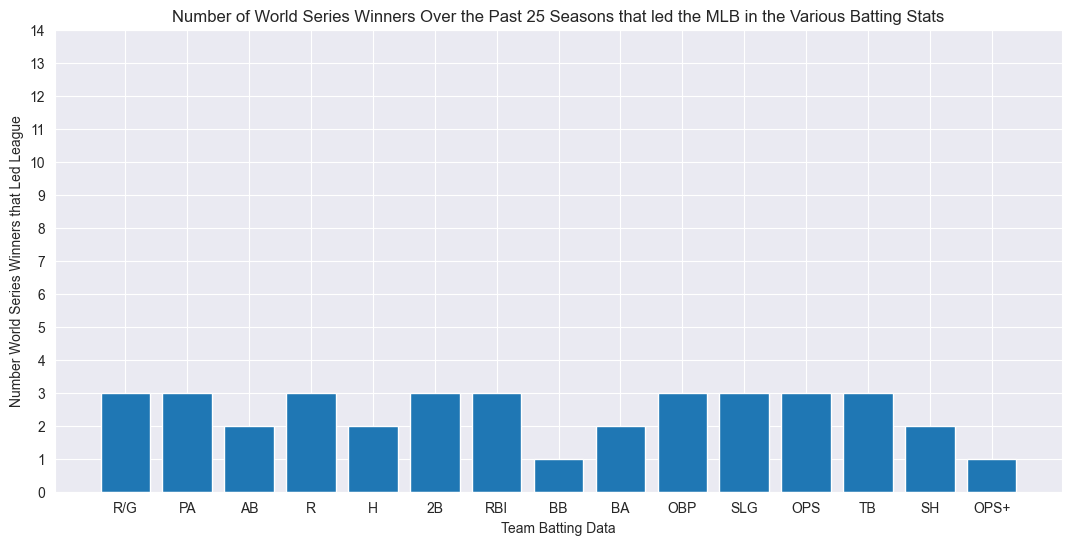

In [54]:
# create bar chart of stats and how often World Series winners led the league in them
plt.bar(stat_counts_dict.keys(), stat_counts_dict.values())
plt.yticks(list(range(15)))

plt.xlabel('Team Batting Data')
plt.ylabel('Number World Series Winners that Led League')
plt.title('Number of World Series Winners Over the Past 25 Seasons that led the MLB in the Various Batting Stats')
plt.gcf().set_size_inches(13, 6)
plt.show()

# 1. Find counts of WS winners in top 3 and/or 5 for each stat
# 2. Use random forest to find out which stats impact each round win most
# 3. Write classifier function (maybe decision tree) to predict if a team will win first round of playoffs (cell value >= 2) based on certain stats. In order to do this need first to write a generalized code that gets stat rank for any team in any season (simpler version can just check if above or below MLB average)

In [55]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

def predict_playoff_outcome(training_start_year, training_end_year, prediction_year, top_teams=8):
    """
    Predicts playoff outcomes for a given year based on historical baseball data.

    Parameters:
    - training_start_year (int): The start year for training the model.
    - training_end_year (int): The end year for training the model.
    - prediction_year (int): The year for which playoff outcomes are to be predicted.
    - top_teams (int): The number of top teams to predict.

    Returns:
    - List[str]: A list of predicted top teams for the specified year.
    """
    # Initialize empty lists for training and testing data
    features_train_list = []
    target_train_list = []

    # Iterate over the range of training years
    for year in range(training_start_year, training_end_year + 1):
        # Call seasonal_data function to get batting and pitching statistics for the current year
        batting_train, pitching_train = seasonal_data(year)

        # Remove the last two rows from both batting and pitching dataframes for the current year
        batting_train = batting_train.iloc[:-2, :]
        pitching_train = pitching_train.iloc[:-2, :]

        # Merge batting and pitching dataframes on the team name for the current year
        data_train = pd.merge(batting_train, pitching_train, on='Tm')

        # Convert 'W' column values to integers for the current year
        data_train['W'] = data_train['W'].astype(int)

        # Assuming 'W' column represents the number of wins for the current year
        target_train_list.append(data_train['W'] >= data_train['W'].median())

        # Select all features (excluding 'Tm') for prediction for the current year
        features_train_list.append(data_train.drop(['W', 'Tm'], axis=1))

    # Concatenate the lists to create the final training features and target DataFrames
    features_train = pd.concat(features_train_list, ignore_index=True)
    target_train = pd.concat(target_train_list, ignore_index=True)

    # Split the training data into training and testing sets
    X_train, _, y_train, _ = train_test_split(features_train, target_train, test_size=0.2, random_state=42)

    # Initialize the decision tree classifier
    clf = DecisionTreeClassifier(random_state=42)

    # Fit the classifier to the training data
    clf.fit(X_train, y_train)

    # Call seasonal_data function to get batting and pitching statistics for prediction year
    batting_pred, pitching_pred = seasonal_data(prediction_year)

    # Remove the last two rows from both batting and pitching dataframes for prediction year
    batting_pred = batting_pred.iloc[:-2, :]
    pitching_pred = pitching_pred.iloc[:-2, :]

    # Merge batting and pitching dataframes on the team name for prediction year
    data_pred = pd.merge(batting_pred, pitching_pred, on='Tm')

    # Use the trained classifier to predict playoff outcome for prediction year
    features_pred = data_pred.drop(['W', 'Tm'], axis=1)
    probabilities = clf.predict_proba(features_pred)[:, 1]

    # Get the top N teams based on predicted probabilities
    top_teams_indices = (-probabilities).argsort()[:top_teams]
    predicted_teams = data_pred.loc[top_teams_indices, 'Tm'].tolist()

    return predicted_teams

In [64]:
predicted_teams_2023 = predict_playoff_outcome(2015, 2022, 2023, top_teams=8)
print(predicted_teams_2023)

/var/folders/6j/6hfn_xvx4c11wy8nsnk0l06c0000gn/T/ipykernel_20441/3810030291.py:32: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  comment_soup = BeautifulSoup(str(comment), 'html.parser')
/var/folders/6j/6hfn_xvx4c11wy8nsnk0l06c0000gn/T/ipykernel_20441/3810030291.py:36: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  pitching = pd.read_html(str(tables[1]))[0]
/var/folders/6j/6hfn_xvx4c11wy8nsnk0l06c0000gn/T/ipykernel_20441/3810030291.py:32: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  comment_soup = BeautifulSoup(str(comment), 'html.parser')
/var/folders/6j/6hfn_xvx4c11wy8nsnk0l06c0000gn/T/ipykernel_20441/3810030291.py:36: FutureWarning: Passi

['Arizona Diamondbacks', 'Texas Rangers', 'Tampa Bay Rays', 'Seattle Mariners', 'San Diego Padres', 'Philadelphia Phillies', 'Oakland Athletics', 'New York Yankees']


In [57]:
playoff_data = pd.read_html('https://www.baseball-reference.com/postseason/')[0]

In [58]:
# rename columns
playoff_data.rename(columns={playoff_data.columns[1]: 'Series Outcome'}, inplace=True)
playoff_data.rename(columns={playoff_data.columns[2]: 'Matchup'}, inplace=True)

In [59]:
year = 2023
temp_slice = playoff_data[playoff_data['Series'].str.contains(str(year), na=False)]
temp_slice.iloc[0:3, 2].str.count('Texas Rangers').sum()

2

In [60]:
# get playoff success for all teams for the past 25 seasons
num_seasons = 25
years = list(map(lambda x: 2023 - x, range(num_seasons)))
year_success = []
playoff_success_df = pd.DataFrame()

for year in years:
    temp_slice = playoff_data[playoff_data['Series'].str.contains(str(year), na=False)]
    year_success = []
    for team in team_abbrevs_dict.keys():
        # check if team won World Series
        if ws_winner_dict[int(year)] == team:
            year_success.append(5)
        # if team didn't win World Series, check if they made it to World Series
        elif team in temp_slice.iloc[0,2]:
        #elif team in temp_slice['Matchup'][0]:
            year_success.append(4)
        # if team didn't make it to World Series, check if they made it to Championship Series (CS)
        elif temp_slice.iloc[1:3, 2].str.count(team).sum() > 0:
        #elif temp_slice['Matchup'][1:3].str.count(team).sum() > 0:
            year_success.append(3)
        # if team didn't make it to CS, check if they made it to Division Series (DS)
        elif temp_slice.iloc[3:7, 2].str.count(team).sum() > 0:
        #elif temp_slice['Matchup'][3:7].str.count(team).sum() > 0:
            year_success.append(2)
        # if team didn't make it to DS, check if they made it to Wild Card (WC) round
        elif temp_slice.iloc[7:, 2].str.count(team).sum() > 0:
        #elif temp_slice['Matchup'][7:].str.count(team).sum() > 0:
            year_success.append(1)
        # if team didn't make playoffs, append 0
        else:
            year_success.append(0)

    year_series = pd.Series(year_success)
    playoff_success_df = pd.concat([playoff_success_df, year_series.to_frame().T])

# make df rows the seasons, make columns the teams/abbrevs, cells all contain 0, 1, 2, 3, 4, or 5
playoff_success_df.columns = list(team_abbrevs_dict.values())
playoff_success_df.index = years

In [61]:
test = pd.DataFrame(playoff_success_df.loc[2023])
team_data_2023 = seasonal_data(2023)

/var/folders/6j/6hfn_xvx4c11wy8nsnk0l06c0000gn/T/ipykernel_20441/3810030291.py:32: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  comment_soup = BeautifulSoup(str(comment), 'html.parser')
/var/folders/6j/6hfn_xvx4c11wy8nsnk0l06c0000gn/T/ipykernel_20441/3810030291.py:36: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  pitching = pd.read_html(str(tables[1]))[0]


In [38]:
from sklearn import tree

In [39]:
def train_dec_tree(year, y_df, max_depth=3, x_stat_list=None, plot=True):
    """ trains a decision tree classifier, optionally prints graph
    
    Args:
        df (pd.DataFrame): dataframe to train on
        max_depth (int): max depth of decision tree
        x_feat_list (list): list of input stats
        plot (bool): toggles graph output (default: True)
        
    Returns:
        dec_tree_clf (DecisionTreeClassifier): trained
            decicision tree
    """
    
    if x_stat_list is None:
        # default x_feat_list
        x_stat_list = ['R/G', 'HR', 'H', 'BA', 'OPS']

    x_df = seasonal_data(year)
    
    # extract data from dataframe
    x = x_df.loc[:, x_stat_list].values
    y = y_df.loc[year].values
    
    # build decision tree classifier
    dec_tree_clf = tree.DecisionTreeClassifier(max_depth=max_depth)

    # fit data
    dec_tree_clf = dec_tree_clf.fit(x, y)
    
    # plot figure of decision tree
    if plot:
        # initialize empty figure (plot_tree sets text size to fill given figure
        # if we resize figure afterwards text size remains too small)
        plt.figure()
        plt.gcf().set_size_inches(15, 10)
        
        # 'plot' decision tree
        tree.plot_tree(dec_tree_clf, 
                       feature_names=x_stat_list)
    
    return dec_tree_clf


In [62]:
train_dec_tree(2023, playoff_success_df)

/var/folders/6j/6hfn_xvx4c11wy8nsnk0l06c0000gn/T/ipykernel_20441/3810030291.py:32: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  comment_soup = BeautifulSoup(str(comment), 'html.parser')
/var/folders/6j/6hfn_xvx4c11wy8nsnk0l06c0000gn/T/ipykernel_20441/3810030291.py:36: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  pitching = pd.read_html(str(tables[1]))[0]


AttributeError: 'tuple' object has no attribute 'loc'

As you can see in the graph above, for every batting stat, at most 3 of the last 10 World Series winners led the league in it the year they won. This is actually a greater percentage than the number of teams that led the MLB in regular season wins the year they won the World Series, which is somewhat promising for our project. One next step could be to expand from only counting World Series winners that led the entire MLB in a stat to counting World Series winners that were one of the top 3 or 5 teams in the MLB for a stat that season. This is likely to increase the counts substantially while still providing relevant info, since top 5 out of 30 teams in still in the highest quintile.

The visualization below displays scatter plots with 2 sets of data points on the each plot: 1 color for the mean values by season, a different color for the set of values for World Series winners by season. We are looking to see if World Series winners consistently had well-above average values for any stat, which would indicate there might be some relationship between that stat and playoff success.

In [63]:
seasons = []
batting_stats = {'H': [],
                'HR': [],
                'RBI': [],
                'BA': [],
                'OPS': []}

# loop backwards through the past n seasons
for i in range(10):
    season = 2023 - i
    seasons.append(season)
    # pull df for current loop's season, set team name as the index
    df_season_batting = get_season_batting_df(season).set_index('Tm')
    time.sleep(4)
    # loop through all the stats in the dictionary initialized above
    for stat in list(batting_stats.keys()):
        # get the average team value for the current stat in the current season
        avg_stat_val = df_season_batting[stat][:30].astype(float).mean()
        
        # get the value for the current stat for the team that won the World Series in the current loop's season
        ws_winner = ws_winners_dict[season]
        ws_winner_stat_val = float(df_season_batting.loc[ws_winner][stat])
        
        # create 2-item list of mean stat value and World Series winner stat value for the current season
        temp_stat_list = [round(avg_stat_val, 3), round(ws_winner_stat_val, 3)]
        # add the 2-item list to list of the respective stat in the batting stats dictionary
        batting_stats[stat].append(temp_stat_list)

NameError: name 'ws_winners_dict' is not defined

In [ ]:
# plot mean team and WS winner values for each stat by season
sns.set_style('darkgrid')
for stat, values in batting_stats.items():
    temp_array = np.array(values)
    plt.scatter(seasons, temp_array[:, 0], label='Mean Value')
    plt.scatter(seasons, temp_array[:, 1], label='WS Winner Value')
    plt.xticks(seasons)
    plt.legend(bbox_to_anchor=(1.4, 1))
    plt.xlabel('Season')
    plt.ylabel(stat.capitalize())
    plt.title(f'Mean and WS Winner {stat.capitalize()} Values by Season')
    plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
import random
from sklearn.ensemble import RandomForestClassifier
##Random Forest Function
def random_forest(year):
    team_data_2023=seasonal_data(year)
    
    types_stats=team_data_2023.columns.tolist()
    
    num_trees=10
    
    max_features = len(types_stats) // 2
    
    for i in range(len(num_trees)):
        
        #selecting random features
        random_features = random.sample(types_stats, k=max_features)
        #creating data copy
        subset_data = team_data_2023[random_features].copy()
        
        
        subset_data['random_order'] = random.sample(range(len(subset_data)), k=len(subset_data))
        
        subset_data.sort_values('random_order', inplace=True)
        
        subset_data.reset_index(drop=True, inplace=True)
        
        train_data = subset_data.iloc[:len(subset_data)//2, :]
        
        tree = RandomForestClassifier(n_estimators=1, max_features=max_features, random_state=42)
        tree.fit(train_data.drop('random_order', axis=1), train_data.index)
        num_trees.append(tree)
    return num_trees
    
    
        
    
    
    
    ##getting different subsets for random rows


random_forest()

URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)>

Almost all World Series winners have been above average in each of the above 5 batting statistics over the last 10 seasons. This supports our conclusions from the first visualization, which is that World Series winners perform well in these categories and that they may be better at predicting playoff success than regular season wins. Another next step will be to look at pitching stats in this same manner.

## Analysis/ML Plan:

The model that we feel that will be most appropriate for this would be a multi variate regression model to calculate the playoff performance and the chance of a team winning the World Series. Further more, we would figure out which which metrics are the greatest predictors of World Series winners. We can investigate linear regression with variety of inputs and predictors such as individual player statistics,payrolls,and injuries to see if we can accuractely predict whether a team will win the World Series. All of these factors could definitely play a roll in our model, however the one that stands out the most would probably be player statistics. Some player statistics that could have a huge impact woould be important stats such as batting average. It would also be important to consider other forms of regresison such as polynomial regresison. In conclusion, we will probably ending using a multi variate regression model to calculate playoff performances.

However, we recognize that playoff performance is a qualitative data point (i.e., "won World Series," "lost in NLCS," etc.), and while it can be quantified (e.g., made playoffs = 1, won Wild Card round = 2, ..., won World Series = 5), there's only a few possible outcomes, which may make regression difficult to implement usefully. Therefore, we expect we might need to switch to more qualitative ML models such as multivariate perceptrons, decision trees, random forests, etc. to get higher utility results. For instance, we might use a team's batting average, OPS, pitching staff ERA, and pitching staff WHIP to predict whether a team will make it to the playoffs - if they do, then predict whether a team will win the Wild Card round ... - until eventually, the remaining teams will be used to predict which will win the World Series.  